# Predicting Abalone age

The purpose of this notebook is to create a model that predicts the age of an abalone from its physical characterstics as accurately as possible.

Data: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Abalone)

## Import Data

In [152]:
# Import libraries
import os
import sys

# Update path for notebook location
sys.path[0] = "../"

from urllib.request import urlretrieve, urlopen

from IPython.display import display, HTML # Display functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_palette("colorblind") 
sns.set_style("darkgrid")

# Set Pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [153]:
# Set remote URL for retrieval
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/'

# Set filenames
filename = 'abalone.data'
names = 'abalone.names'

# Download raw data
urlretrieve(URL + filename, '../data/raw/' + filename);

# Download column names
urlretrieve(URL + names, '../data/raw/' + names);

In [154]:
# Read in names from text file
with open('../data/raw/abalone.names', 'r') as names:
    lines = list(names)

# Names - for now use this list
names = ['Sex', 'Length', 'Diameter', 'Height', 'WeightWhole', 
         'WeightShucked', 'WeightViscera', 'WeightShell', 'RingCount']

# Read in data
raw = pd.read_csv('../data/raw/abalone.data', names=names, header=None, sep=',');

In [155]:
raw.head()

,Sex,Length,Diameter,Height,WeightWhole,WeightShucked,WeightViscera,WeightShell,RingCount
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## EDA

In [156]:
raw.shape

(4177, 9)

In [157]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex              4177 non-null object
Length           4177 non-null float64
Diameter         4177 non-null float64
Height           4177 non-null float64
WeightWhole      4177 non-null float64
WeightShucked    4177 non-null float64
WeightViscera    4177 non-null float64
WeightShell      4177 non-null float64
RingCount        4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


The dataset has no missing values or incorrect datatypes.

### Categorical Features

#### Sex

Sex is the only categorical variable. It has 3 classes: 
- M: male
- F: female
- I: infant

In [160]:
# Convert dtype to category
#assert (raw['Sex'].dtype == 'category') | (raw['Sex'].dtype == 'object'), "dtype must be 'category' or 'object'."

Examine distribution:

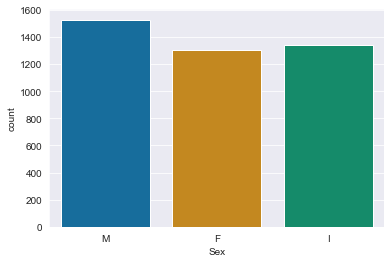

In [161]:
sns.countplot(x="Sex", data=raw);

There are 3 categories in the Sex column and the classes appear to be adequately balanced.

### Continuous Numeric Features

In [162]:
# Selects continuous numeric datatypes
raw_numeric_cont = raw.select_dtypes(include='float64')
raw_numeric_cont.head()

,Length,Diameter,Height,WeightWhole,WeightShucked,WeightViscera,WeightShell
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


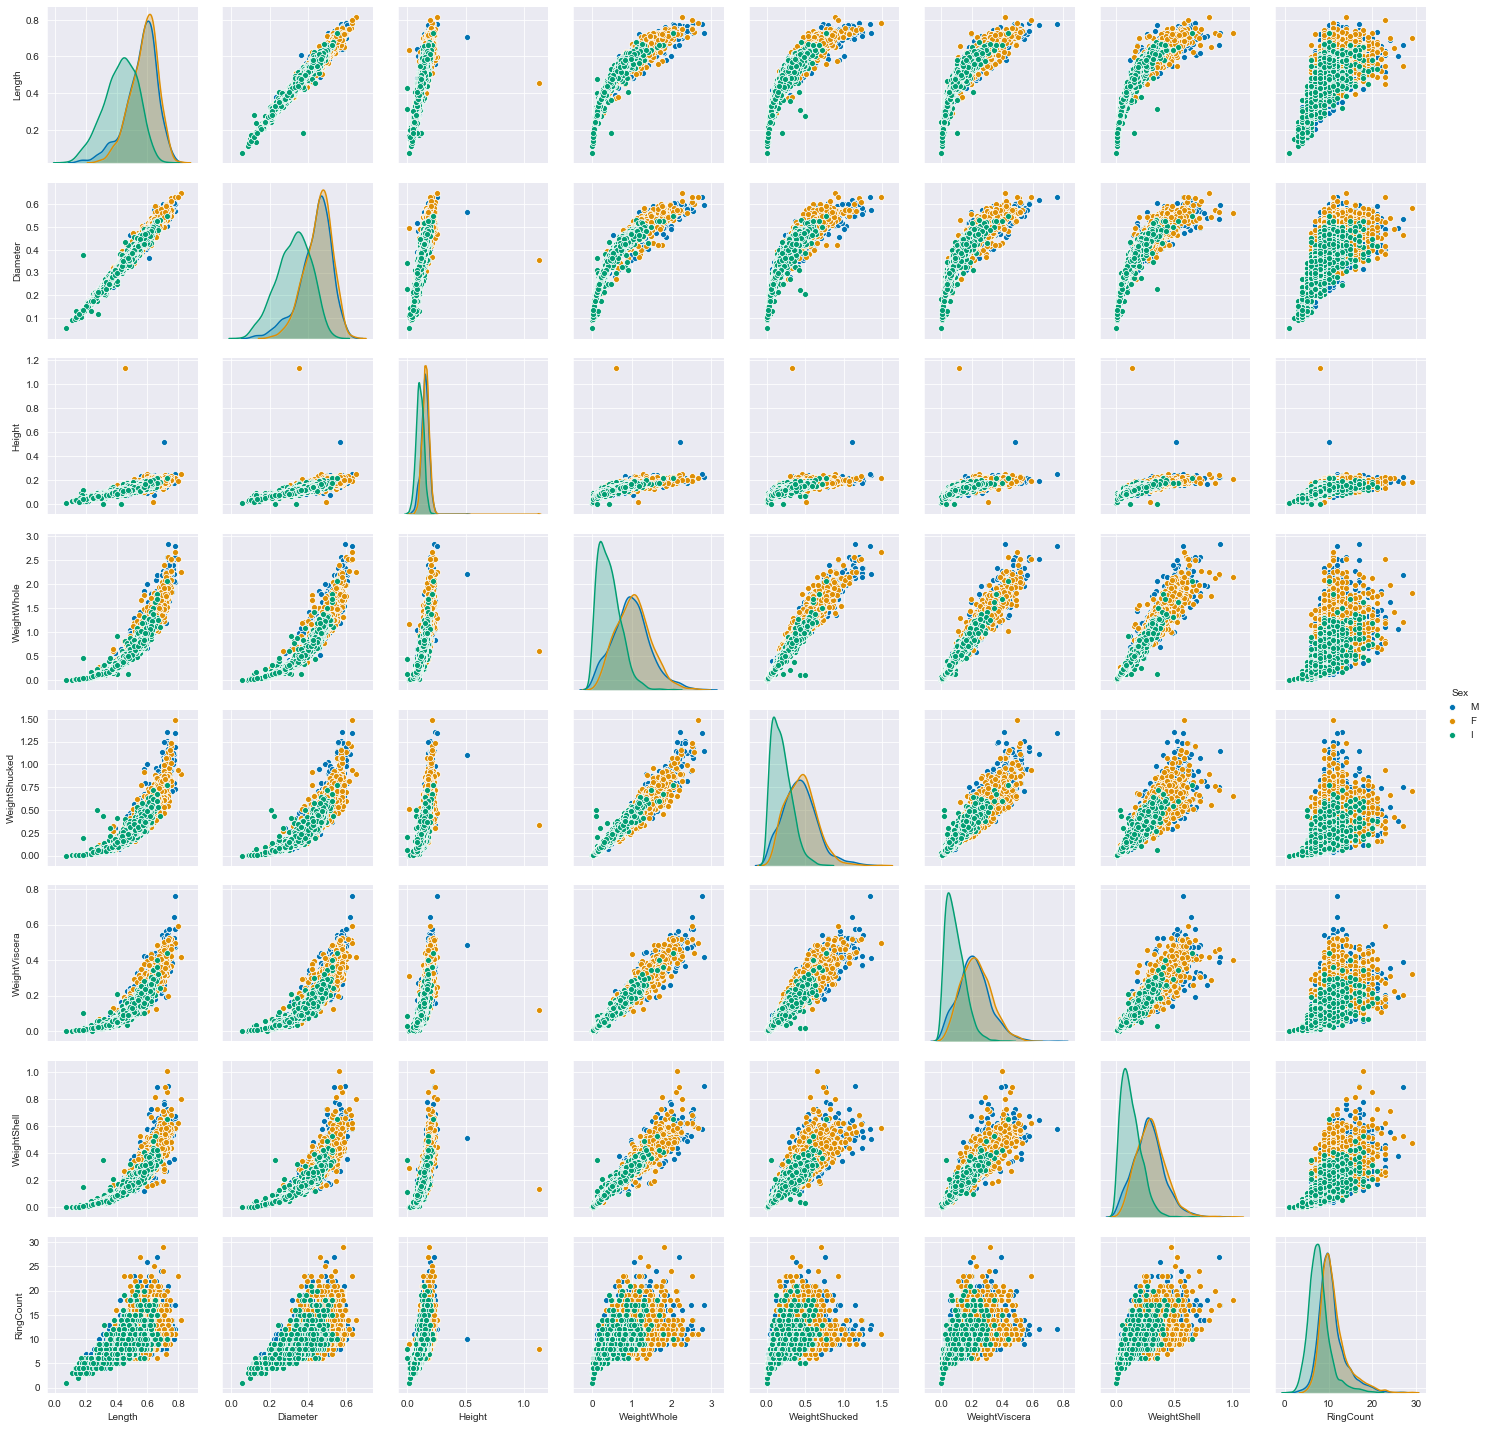

In [164]:
# Pairplots all continuous numeric features
sns.pairplot(raw, hue="Sex");

At a glance the pairplot shows some right skew on Length and Diameter, and left skew on the 4 weight columns. There are also some strong correlations present among features, as well as some outliers. The Height column should be examined more closely.



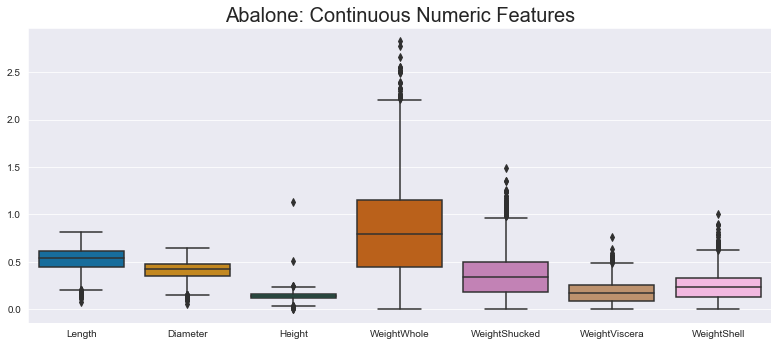

In [136]:
# Plots boxplot of continuous numeric features
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.boxplot(data=raw_numeric_cont, ax=ax)
plt.title("Abalone: Continuous Numeric Features", fontsize=20)
plt.tight_layout(pad=5)
plt.show()

### Discrete Numeric Features

The only feature of this type is the RingCount column, which indicates the age of the individual. This will be the target variable for the model to predict.

In [137]:
# Selects discrete numeric features
raw.select_dtypes(include='int').head()

,RingCount
0,15
1,7
2,9
3,10
4,7


Since age is a finite variable, we can look at the number of individuals of each age:

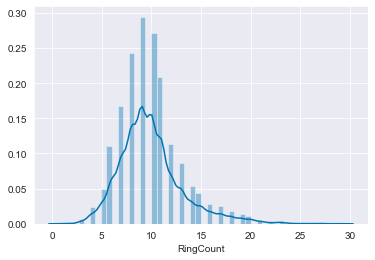

In [143]:
sns.distplot(raw["RingCount"]);

There is slight skew in the age towards younger individuals. Perhaps their probability of being harvested or eaten increases once they exceed a certain size.

## Preprocessing Methods

Models will be compared with and without the standardization and normalization steps.

**Sex** 
* Create dummies

**Length, Diameter**
* Standardize
* Remove Outliers

**Height**
* Remove Outliers

**WeightWhole, WeightShucked, WeightViscera, WeightShell**
* Normalize